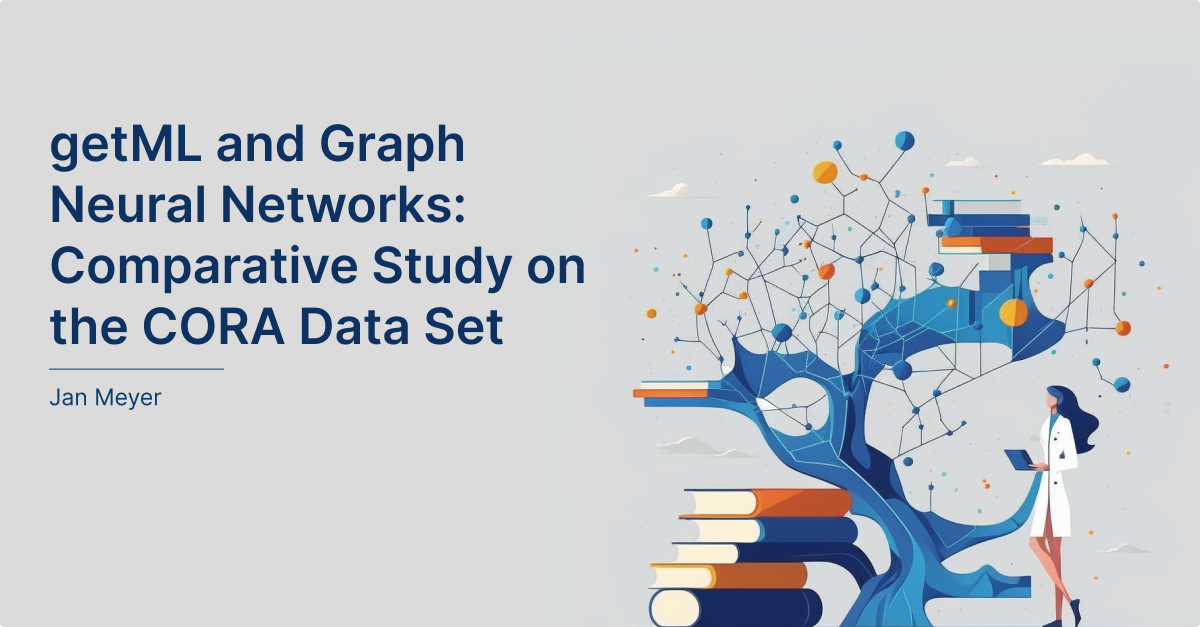

In recent years, Graph Neural Networks have gained a lot of attention in the data science community. An established benchmark to track and compare the progress of its development is the CORA classification data set. It consists of academic papers, their domain, word content of their abstracts, and how they reference each other. The challenge posed by the CORA data set is: Determine the domain of a paper, based on its references and the word content of its abstracts.

The paper's references give rise to a complex graph structure, while the word content form an appropriate input for neural networks. Hence, GNN's are extremely well suited to be applied to the data set. The popularity of CORA among GNN researchers is underscored by the fact, that the renowned tracking site Papers with Code lists 69 papers benchmarking on CORA since 2016 (https://paperswithcode.com/sota/node-classification-on-cora), the vast majority of which are GNN based. Therefore, it makes sense to put the power of [getML](https://getml.com/)'s automatic feature engineering to test by directly comparing it to state of the art GNN approaches in the context of the CORA data set.

This notebook looks at efforts required and performance in terms of accuracy to compare both approaches.

# Setup and Download of Data

First install the dependencies. Don't be discouraged, that may take a few minutes. Make sure you use Python 3.9.19.

In [1]:
# Install multiple Python packages in a single command for efficiency
%pip install -q "getml==1.4.0" "torch-geometric~=2.5" "pandas~=2.2" "matplotlib~=3.9" "seaborn~=0.13" "numpy~=1.26" "torch~=2.4"

# Download and extract getML software
!wget -q https://static.getml.com/download/1.4.0/getml-1.4.0-x64-linux.tar.gz
!tar -xzf getml-1.4.0-x64-linux.tar.gz >/dev/null 2>&1

# Install getML
!./getml-1.4.0-x64-linux/getML install


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Installing getML...
Could not install into '/usr/local': mkdir /usr/local/getML: permission denied
Global installation failed, most likely due to missing root rights. Trying local installation instead.
Installing getML...


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import seaborn as sns

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import getml

In [3]:
getml.engine.launch()
getml.engine.set_project("cora")

Launching ./getML --allow-push-notifications=true --allow-remote-ips=false --home-directory=/home/alex --in-memory=true --install=false --launch-browser=true --log=false in /home/alex/.getML/getml-1.4.0-x64-linux...
Launched the getML engine. The log output will be stored in /home/alex/.getML/logs/20240826151248.log.

Connected to project 'cora'


In [4]:
conn = getml.database.connect_mysql(
    host="db.relational-data.org",
    dbname="CORA",
    port=3306,
    user="guest",
    password="relational",
)

To ensure comparability, the data set will be loaded from a single source. In real life, the provision of data in the appropriate graph structure is extremely unlikely. Hence, to mimic a typical setting of data availability, we choose to set out with the data in tabular format.

In [5]:
def load_if_needed(name):
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(name=name, table_name=name, conn=conn)
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [6]:
paper = load_if_needed("paper")
cites = load_if_needed("cites")
content = load_if_needed("content")

In [7]:
paper_df = paper.to_pandas()
cites_df = cites.to_pandas()
content_df = content.to_pandas()

Check out the image at https://graphsandnetworks.com/the-cora-dataset/. It shows the entire Cora graph, including all papers and all references.

# Graph Neural Networks
## Nodes
### Node attribute: Vectorization of words

In order to model the CORA dataset as a graph structure, we need to define its constituents: nodes and edges. Nodes represent papers and edges represent references. As an additional source of information, the word composition of the paper's abstracts play a major role in determining the paper's class (i.e. domain). To make the word information accessible to the Neural Networks within the GNN architecture, the words lists need to be represented as a matrix. Using a bag of words approach, the words are being one-hot-encoded. Within GNN terminology, the resulting vectors of constant length form the node attributes.

In [8]:
def vectorize(word_list):
    word_vector = np.zeros(vocab_size, dtype=int)
    word_vector[word_list] = 1
    return word_vector


vocab_size = content_df["word_cited_id"].nunique() + 1

content_df["paper_id"] = content_df["paper_id"].astype(int)
content_df["word_list"] = content_df["word_cited_id"].apply(lambda x: int(x[4:]) - 1)
vector_content_df = content_df.groupby("paper_id").agg(list)
vector_content_df["word_vector"] = vector_content_df["word_list"].apply(
    lambda x: vectorize(x)
)

The class labels we want to predict also need to be properly encoded. For convenience the mapping between code and label name is saved in a dictionary.

In [9]:
paper_df["paper_id"] = paper_df["paper_id"].astype(int)
paper_df["class_label_enc"] = paper_df["class_label"].astype("category").cat.codes
num_classes = paper_df["class_label_enc"].nunique()

_df = paper_df[["class_label_enc", "class_label"]].drop_duplicates()
_df.index = _df.class_label_enc
label_mapping = _df.sort_index().to_dict()["class_label"]

### Node index

Each paper forms one node. Within the GNN architecture, nodes are identified by their index. Therefore it is crucial to create a single source of truth, where the node attributes have the same index. The paper and content dataframes are merged to ensure that congruency.

In [10]:
index_alligned_df = paper_df.merge(vector_content_df, on="paper_id")
index_alligned_df = index_alligned_df.sample(frac=1, random_state=1234).reset_index(
    drop=True
)  # Randomization step
index_alligned_df["node_index"] = index_alligned_df.index

## Edges

Edges constitute the other basic building block of a graph. An edge is simply defined as a tuple of two node indices: the sending node and the receiving node. The citation dataframe holds this information. To extent the newly imposed node_index nomenclatura, the citation dataframe is updated with the correct node indices.

In [11]:
cites_df = cites_df.astype({"cited_paper_id": int, "citing_paper_id": int})

cites_df = cites_df.merge(
    index_alligned_df[["paper_id", "node_index"]],
    how="left",
    left_on="cited_paper_id",
    right_on="paper_id",
    copy=False,
)
cites_df.rename(columns={"node_index": "cited_node_index"}, inplace=True)
cites_df.drop("paper_id", axis=1, inplace=True)

cites_df = cites_df.merge(
    index_alligned_df[["paper_id", "node_index"]],
    how="left",
    left_on="citing_paper_id",
    right_on="paper_id",
    copy=False,
)
cites_df.rename(columns={"node_index": "citing_node_index"}, inplace=True)
cites_df.drop("paper_id", axis=1, inplace=True)
cites_df

,cited_paper_id,citing_paper_id,cited_node_index,citing_node_index
0,35,887,545,77
1,35,1033,545,249
2,35,1688,545,1409
3,35,1956,545,1010
4,35,8865,545,2073
...,...,...,...,...
5424,853116,19621,491,709
5425,853116,853155,491,2440
5426,853118,1140289,116,2375
5427,853155,853118,2440,116


### Edge Index

The edge_index tensor is the collection of all edges and represents the node connectivity of a graph.
Edges can be directed or undirected. In the current case, we do not differentiate whether a paper cites another paper or is cited. That is why we treat every connection as undirectional, append the edge_index with the reverse of the already existing directed edge.

In [12]:
_cited_node = cites_df["cited_node_index"].values
_citing_node = cites_df["citing_node_index"].values

cited_node = np.concatenate((_citing_node, _cited_node))
citing_node = np.concatenate((_cited_node, _citing_node))

## Train Test Split

In order to maintain comparability, we ensure that for each run, test and training data are identical for both the GNN getML approach. The masks are easily integrable with the graph object, as well as with the getML semantics in a later step. The actual randomization takes place during the defintion of the node_index a few lines above.

In [13]:
train_share = 0.7
n_papers = len(index_alligned_df)
cut_off = int(n_papers * train_share)
train_mask = n_papers * [False]
train_mask[:cut_off] = cut_off * [True]
test_mask = [not e for e in train_mask]

## Graph Object

Now, the actual work on the graph object can begin. Predictors, targets and edge index are converted to torch tensors. The Graph object is instantiated and populated with the data and masks.

In [14]:
x = torch.tensor(
    np.array(index_alligned_df.word_vector.values.tolist()), dtype=torch.float32
)

y = torch.tensor(
    np.array(index_alligned_df["class_label_enc"].values), dtype=torch.long
)
edge_index = torch.tensor(np.array([cited_node, citing_node]), dtype=torch.int64)

graph_object = Data(x=x, edge_index=edge_index, y=y)
graph_object.train_mask = torch.tensor(train_mask)
graph_object.test_mask = torch.tensor(test_mask)

## Exploratory Analysis

To get a better grasp of the graph object we examine several of its features.

In [15]:
print(graph_object)
print("==============================================================")

print(f"Number of nodes: {graph_object.num_nodes}")
print(f"Number of edges: {int(graph_object.num_edges/2)}")
print(f"Average node degree: {(graph_object.num_edges) / graph_object.num_nodes:.2f}")
print(f"Number of training nodes: {graph_object.train_mask.sum()}")
print(f"Number of test nodes: {graph_object.test_mask.sum()}")
print(
    f"Training node label rate: {int(graph_object.train_mask.sum()) / graph_object.num_nodes:.2f}"
)
print(
    f"Test node label rate: {int(graph_object.test_mask.sum()) / graph_object.num_nodes:.2f}"
)
print(f"Contains isolated nodes: {graph_object.has_isolated_nodes()}")
print(f"Contains self-loops: {graph_object.has_self_loops()}")
print(f"Is undirected: {graph_object.is_undirected()}")

Data(x=[2708, 1433], edge_index=[2, 10858], y=[2708], train_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 5429
Average node degree: 4.01
Number of training nodes: 1895
Number of test nodes: 813
Training node label rate: 0.70
Test node label rate: 0.30
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


It would be interesting to learn what is the connectivity of papers across topics. The following heatmap shows the share of references within a domain on its diagonal, and across domains off the diagonal. "Theory" seems to be most cross-referenced of all domains, which makes sense since it often forms the fundament for more advanced research.

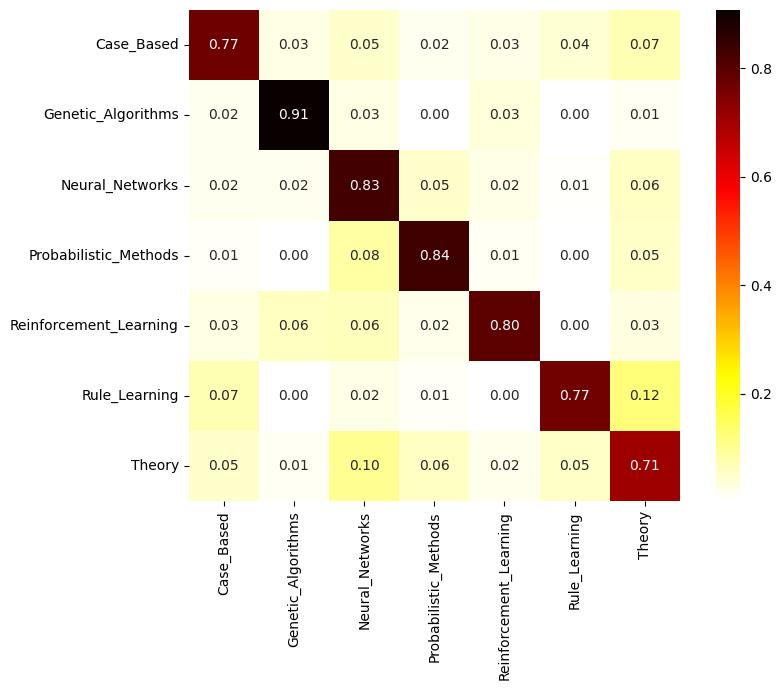

In [16]:
labels = graph_object.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], graph_object.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)

label_connection_counts = []
for i in range(7):
    connected_labels = connected_labels_set[
        :, np.where(connected_labels_set[0] == i)[0]
    ]
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)


def scaling(array):
    return array / sum(array)


label_connection_counts_scaled = np.apply_along_axis(
    scaling, 1, label_connection_counts
)
connection_df = pd.DataFrame(
    label_connection_counts_scaled,
    columns=label_mapping.items(),
    index=label_mapping.items(),
)
connection_df = connection_df.droplevel(level=0, axis=0)
connection_df = connection_df.droplevel(level=0, axis=1)

plt.figure(figsize=(9, 7))
hm = sns.heatmap(
    connection_df, annot=True, cmap="hot_r", fmt="1.2f", cbar=True, square=True
)

plt.tight_layout()
plt.show()

## Modeling

The GNNTrain object contains the training routine that trains and tests the model every epoch.

In [17]:
class GNNTrain:
    def __init__(self, graph_object, nn_model):
        self.graph_object = graph_object
        self.nn_model = nn_model
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            nn_model.parameters(), lr=0.01, weight_decay=5e-4
        )

    def train(self):
        self.nn_model.train()
        self.optimizer.zero_grad()
        out = self.nn_model(self.graph_object.x, self.graph_object.edge_index)
        loss = self.loss_function(
            out[self.graph_object.train_mask],
            self.graph_object.y[self.graph_object.train_mask],
        )
        loss.backward()  # compute loss
        self.optimizer.step()  # apply grad
        return loss

    def test(self, mask):
        self.nn_model.eval()
        out = self.nn_model(self.graph_object.x, self.graph_object.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask] == self.graph_object.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
        return acc

    def run(self):
        max_test_acc = 0
        test_acc_list = []
        for epoch in range(1, 1001):
            self.train()
            train_acc = self.test(self.graph_object.train_mask)
            test_acc = self.test(self.graph_object.test_mask)
            test_acc_list.append(test_acc)
            if test_acc > max_test_acc:
                max_test_acc = test_acc
            if epoch % 100 == 0:
                print(
                    f"Epoch: {epoch:03d}, Train acc: {train_acc:.4f}"
                    f", Test acc: {test_acc:.4f}"
                )
        self.test_acc_list = test_acc_list
        self.max_test_acc = max_test_acc

Now, the GNNTrain object is instantiated. We choose a neural layer supported by pytorch.geometric, pass the previousy created graph objected and let the .run() do its job.

In [18]:
nn_model = GCNConv(
    in_channels=graph_object.num_features, out_channels=len(graph_object.y.unique())
)
gcn = GNNTrain(graph_object=graph_object, nn_model=nn_model)
gcn.run()
print("Maximum Test Accuracy: ", gcn.max_test_acc)

Epoch: 100, Train acc: 0.9588, Test acc: 0.8721
Epoch: 200, Train acc: 0.9631, Test acc: 0.8733
Epoch: 300, Train acc: 0.9636, Test acc: 0.8696
Epoch: 400, Train acc: 0.9662, Test acc: 0.8721
Epoch: 500, Train acc: 0.9673, Test acc: 0.8696
Epoch: 600, Train acc: 0.9673, Test acc: 0.8708
Epoch: 700, Train acc: 0.9673, Test acc: 0.8721
Epoch: 800, Train acc: 0.9678, Test acc: 0.8708
Epoch: 900, Train acc: 0.9678, Test acc: 0.8708
Epoch: 1000, Train acc: 0.9678, Test acc: 0.8708
Maximum Test Accuracy:  0.8782287822878229


Using the graph convolutional operater GCNConv, the best accuracy that has been attained on the test data set is 87.82%. Let's turn to relation feature engineering employed by getML and examine its performance under identical conditions.

# getML Implementation
*For a more detailed description and in depth feature analysis of the getML approach to the CORA data set check out: https://github.com/getml/getml-demo/blob/master/cora.ipynb*

Unlike in a standalone approach of a getML solution, we do not randomize train and test data. Instead, we utilize the identical train test split that was used for the GNN implementation. To this end, the index_aligned_df and the identical masks from previously are used.

In [19]:
data_train = getml.DataFrame.from_pandas(
    index_alligned_df[["paper_id", "class_label"]][train_mask], name="data_train"
)
data_test = getml.DataFrame.from_pandas(
    index_alligned_df[["paper_id", "class_label"]][test_mask], name="data_test"
)

paper, split = getml.data.split.concat("population", train=data_train, test=data_test)

In [20]:
getml.DataFrame.from_pandas(
    index_alligned_df[["paper_id", "class_label"]][train_mask], name="data_train"
)

name,paper_id,class_label
role,unused_float,unused_string
0,1124844,Neural_Networks
1,17208,Reinforcement_Learning
2,63931,Rule_Learning
3,12165,Theory
4,1122425,Reinforcement_Learning
,...,...
1890,1154176,Genetic_Algorithms
1891,1113742,Genetic_Algorithms
1892,1952,Case_Based


### Role Setting

getML requires that we define *roles* for each of the columns.

Also, the goal is to predict seven different labels. We generate a target column for each of those labels.

In [21]:
paper.set_role("paper_id", getml.data.roles.join_key)
paper.set_role("class_label", getml.data.roles.categorical)

cites.set_role(["cited_paper_id", "citing_paper_id"], getml.data.roles.join_key)

content.set_role("paper_id", getml.data.roles.join_key)
content.set_role("word_cited_id", getml.data.roles.categorical)

data_full = getml.data.make_target_columns(paper, "class_label")

In [22]:
container = getml.data.Container(population=data_full, split=split)
container.add(cites=cites, content=content, paper=paper)
container.freeze()

### Data Model

To get started with relational learning, we need to specify the data model. Even though the data set itself is quite simple with only three tables and six columns in total, the resulting data model is actually quite complicated.

That is because the class label can be predicted using three different pieces of information:

- The keywords used by the paper
- The keywords used by papers it cites and by papers that cite the paper
- The class label of papers it cites and by papers that cite the paper

The main challenge here is that `cites` is used twice, once to connect the _cited_ papers and then to connect the _citing_ papers. To resolve this, we need two placeholders on `cites`.

In [23]:
dm = getml.data.DataModel(paper.to_placeholder("population"))

# We need two different placeholders for cites.
dm.add(getml.data.to_placeholder(cites=[cites] * 2, content=content, paper=paper))

dm.population.join(dm.cites[0], on=("paper_id", "cited_paper_id"))

dm.cites[0].join(dm.content, on=("citing_paper_id", "paper_id"))

dm.cites[0].join(
    dm.paper,
    on=("citing_paper_id", "paper_id"),
    relationship=getml.data.relationship.many_to_one,
)

dm.population.join(dm.cites[1], on=("paper_id", "citing_paper_id"))

dm.cites[1].join(dm.content, on=("cited_paper_id", "paper_id"))

dm.cites[1].join(
    dm.paper,
    on=("cited_paper_id", "paper_id"),
    relationship=getml.data.relationship.many_to_one,
)

dm.population.join(dm.content, on="paper_id")

dm

,data frames,staging table
0,population,POPULATION__STAGING_TABLE_1
1,"cites, paper",CITES__STAGING_TABLE_2
2,"cites, paper",CITES__STAGING_TABLE_3
3,content,CONTENT__STAGING_TABLE_4


We use the FastProp algorithm for feature engineering and XGBoost for classification.

In [24]:
mapping = getml.preprocessors.Mapping()

fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1,
)

predictor = getml.predictors.XGBoostClassifier()

### Build the Pipeline

In [25]:
pipe1 = getml.pipeline.Pipeline(
    tags=["fast_prop"],
    data_model=dm,
    preprocessors=[mapping],
    feature_learners=[fast_prop],
    predictors=[predictor],
)

pipe1

Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['cites', 'content', 'paper'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop'])

### Model training

In [26]:
pipe1.fit(container.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Checking... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 3 issues labeled INFO and 0 issues labeled WARNING.
To see the issues in full, run .check() on the pipeline.

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Trying 3780 features... 100% |██████████| [elapsed: 00:08, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
XGBoost: Training as predictor... 100% |██████████| [elapsed: 00:01, 

Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['cites', 'content', 'paper'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop', 'container-1UHYiW'])

### Out of Sample Prediction

In order to obtain the accuracy of our model we need to transform the computed probabilities in actual categorical predictions and compare them with the ground truth.

In [27]:
probabilities1 = pipe1.predict(container.test)
class_label = paper.class_label.unique()

ix_max = np.argmax(probabilities1, axis=1)
predicted_labels1 = np.asarray([class_label[ix] for ix in ix_max])

actual_labels = paper[split == "test"].class_label.to_numpy()

print("Share of accurately predicted class labels (pipe1):")
print((actual_labels == predicted_labels1).sum() / len(actual_labels))

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

Share of accurately predicted class labels (pipe1):
0.8879310344827587


## Conclusion

With automatic feature engineering we attain 88.79% accuracy. Randomizing over train test split we found in large scale test runs, that on average getML feature engineering reaches an accuracy of 88.3%, whereas GNN's attain on average 87.6%.
That means with little effort, getML FastProp algorithm outperforms off-the-shelf GNN implementations. And even compared with cutting edge GNN research, getML ranks well within the TOP 10 among all papers ever published.

Stay tuned for our next notebook, where we combine getML feature engineering and off-the-shelf GNN implementaions and vastly outperform cutting edge GNN implementations.